### 二次元リストから生成

In [1]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

import pandas as pd

# 1 各行を一つのリストとして並べる

list = [
    [1, 100, 0.33, 'AAA', 'AAA100'], 
    [2, 200, 0.67, 'BBB', 'BBB200'], 
    [3, 300, 1, 'CCC', 'CCC300'], 
    [4, 400, 1.33, 'DDD', 'DDD400'], 
    [5, 500, 1.67, 'EEE', 'EEE500'], 
    [6, 600, 2, 'FFF', 'FFF600']
]

# 2 表に変換
# pd.DataFrame(list) : pandasのDataFrameで表に変換
df = pd.DataFrame(list)
# 行名・列名は自動で割り振られた番号になっている

# 3 行名の変更
df.index = ['row0', 'row1', 'row2', 'row3', 'row4', 'row5']

# 4 列名の変更
df.columns = ['col0', 'col1', 'col2', 'col3', 'col4']

df

# 1 各行を一つのリストとして並べる
list = [
[1, 100, 0.33, 'AAA', 'AAA100'], 
[2, 200, 0.67, 'BBB', 'BBB200'], 
[3, 300, 1, 'CCC', 'CCC300'], 
[4, 400, 1.33, 'DDD', 'DDD400'], 
[5, 500, 1.67, 'EEE', 'EEE500'], 
[6, 600, 2, 'FFF', 'FFF600']]


#2 表に変換(オプションで行列名を指定)
ind = ['row0', 'row1', 'row2', 'row3', 'row4', 'row5']
col = ['col0', 'col1', 'col2', 'col3', 'col4']

df = pd.DataFrame(list, index=ind, columns=col)


df

# 1 各行を一つのリストにする
list = [
['row0', 1, 100, 0.33, 'AAA', 'AAA100'], 
['row1', 2, 200, 0.67, 'BBB', 'BBB200'], 
['row2', 3, 300, 1, 'CCC', 'CCC300'], 
['row3', 4, 400, 1.33, 'DDD', 'DDD400'], 
['row4', 5, 500, 1.67, 'EEE', 'EEE500'], 
['row5', 6, 600, 2, 'FFF', 'FFF600'], ]

# 2 表に変換
df = pd.DataFrame(list)

# 3 列名を変更
df.columns = ['', 'col0', 'col1', 'col2', 'col3', 'col4']

# 4 行名となる列を指定
df = df.set_index('')

df

# 1 各行ごとのリストを作成

listA = [1, 100, 0.33, 'AAA', 'AAA100']
listB = [2, 200, 0.67, 'BBB', 'BBB200']
listC = [3, 300, 1, 'CCC', 'CCC300']
listD = [4, 400, 1.33, 'DDD', 'DDD400']
listE = [5, 500, 1.67, 'EEE', 'EEE500']
listF = [6, 600, 2, 'FFF', 'FFF600']

# 2 まとめて表に変換

df = pd.DataFrame([listA, listB, listC, listD, listE, listF])

# 3 行名の変更
df.index = ['row0', 'row1', 'row2', 'row3', 'row4', 'row5']

# 4 列名の変更
df.columns = ['col0', 'col1', 'col2', 'col3', 'col4']

del list

df

,col0,col1,col2,col3,col4
row0,1,100,0.33,AAA,AAA100
row1,2,200,0.67,BBB,BBB200
row2,3,300,1.00,CCC,CCC300
row3,4,400,1.33,DDD,DDD400
row4,5,500,1.67,EEE,EEE500
row5,6,600,2.00,FFF,FFF600


In [2]:
cg_c_data = return_dict_summary_fixed()

In [3]:
x = cg_c_data["processes"]
y = cg_c_data["ICNVRT"]

In [4]:
cg_icnvrt_lr = ModelLog10(x, y, "CG", "ICNVRT")

In [5]:
cg_icnvrt_lr.calc_lr()

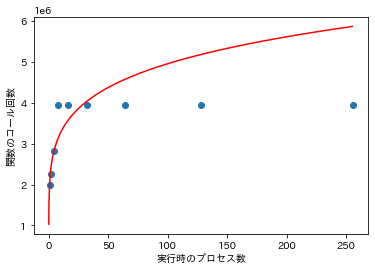

In [6]:
cg_icnvrt_lr.plot_graph()

In [7]:
max_in_y = max(y)
# 最大値の個数を取得
y.tolist().count(max_in_y)
# 最大値のインデックスで最小のもの
y.tolist().index(max_in_y)

3

In [8]:
class ModelBranch(ModelBase):
    
    def calc_lr(self):
        # 後述する t を算出するための処理
        max_in_train_y = max(self.train_y)
        max_in_train_y_first_index = self.train_y.tolist().index(max_in_train_y)
        # 分岐点のインデックスを t とする
        t = max_in_train_y_first_index
        self.t = t
        if(self.t == 0 or self.t == len(self.train_y) - 1):
            self.lr = LinearRegression()
            self.lr.fit(self.train_x, self.train_y)
        else:
            x_train_1 = self.train_x[:t]
            x_train_2 = self.train_x[t:]
            y_train_1 = self.train_y[:t]
            y_train_2 = self.train_y[t:]
            self.lr1 = LinearRegression()
            self.lr1.fit(x_train_1, y_train_1)
            self.lr2 = LinearRegression()
            self.lr2.fit(x_train_2, y_train_2)
        
    def calc_mape_score(self):
        if(self.t == 0 or self.t == len(self.train_y) - 1):
            test_y_predicted = self.lr.predict(self.test_x)
            self.mape_score = float(mape_score(self.test_y, test_y_predicted))
        else:
            x_test = self.test_x
            y_test = self.test_y
            y_test_predicted = self.lr2.predict(x_test)
            self.mape_score = float(mape_score(y_test, y_test_predicted))
        
    def plot_graph(self):
        plt.figure()
        plt.scatter(self.raw_x, self.raw_y)

        if(self.t == 0 or self.t == len(self.train_y) - 1):
            y_model_line = self.lr.predict(x_model_line)
            plt.plot(self.x_model_line, y_model_line, color="red")
        else:
            # 回帰曲線を二つのモデルで分割するための処理
            x_model_line = self.x_model_line
            t_in_model_line = 0
            for i in range(len(x_model_line)):
                if (self.train_x[self.t] < x_model_line[i]):
                    t_in_model_line = i
                    break
                else:
                    t_in_model_line = i
            
            x_model_line1 = self.x_model_line[:t_in_model_line]
            x_model_line2 = self.x_model_line[t_in_model_line:]
            y_model_line1 = self.lr1.predict(x_model_line1)
            y_model_line2 = self.lr2.predict(x_model_line2)

            plt.plot(x_model_line1, y_model_line1, color="red")
            plt.plot(x_model_line2, y_model_line2, color="red")
    #         plt.plot(self.test_x, self.test_y, color="yellow")
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        

0.0


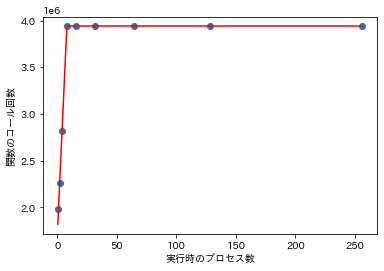

In [9]:
model_branch = ModelBranch(x, y, "CG", "ICNVRT")

model_branch.calc_lr()

model_branch.calc_mape_score()

print(model_branch.mape_score)

model_branch.plot_graph()

In [10]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

In [11]:
# ~~~_excludeBTSP, ~~~_onlyBTSP はそれぞれのベンチマークで取得したプロセス数
processes_excludeBTSP = [1, 2, 4, 8, 16, 32, 64, 128, 256]
processes_onlyBTSP = [1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 169, 196, 225]

In [12]:
# 引数に横軸：プロセス数orベンチマーククラス, 縦軸：関数名となっているデータフレームを取る
# 返値として
# rowData:プロセス数のリスト もしくは プロセス数のリスト (引数に由来)
# 各種関数名：実行回数のリスト
# 以上のような関係の辞書を返す

def return_dict_Data(DataFrame):
    columns = DataFrame.columns.to_numpy()
    index = DataFrame.index.to_numpy()
    # 返値となる辞書return_dictに引数のデータフレームの列名(プロセス数orベンチマーククラス)を格納
    return_dict = {"rowData":columns}
    for index_name in index:
        return_dict[index_name] = DataFrame.T[index_name].to_numpy()
    
    return return_dict


In [13]:
### 引数にx軸となる値のリスト, y軸となる値のリスト, 関数名の文字列の三つをとる
### 返り値は次のようなリスト
### [<関数名の文字列>, <線形モデルのMAPE値>, <対数モデルのMAPE値>, <反比例モデルのMAPE値>]
def return_Mape_row_list(x :list, y :list, function_name :str):

    # 変数：model_lin
    # 線形モデル
    model_lin = ModelLin(x, y)
    model_lin.calc_lr()
    model_lin.calc_mape_score()

    # 変数：model_log
    # 対数モデル
    model_log = ModelLog10(x, y)
    model_log.calc_lr()
    model_log.calc_mape_score()

    # 変数：model_ip
    # 反比例モデル
    model_ip = ModelIP(x, y)
    model_ip.calc_lr()
    model_ip.calc_mape_score()

    # 変数：model_branch
    # 特異点付き条件分岐モデル
    model_branch = ModelBranch(x, y)
    model_branch.calc_lr()
    model_branch.calc_mape_score()

    # 変数：return_list
    # 返り値となるリスト
    return_list = [function_name, model_lin.mape_score, model_log.mape_score, model_ip.mape_score, model_branch.mape_score]
    return(return_list)

In [14]:
### 引数に「return_dict_DataFrame()」の返り値をとる
### 返り値は行・列がモデル名・関数名で要素がMAPE値となっているDataFrame
def return_MapeTable_per_benchmark(dict_data :dict):

    # 変数：_names
    # 引数の辞書のプロセス数もしくはベンチマーククラスの文字列のリスト
    _names = dict_data['rowData']
    # 変数：function_names
    # 引数の辞書の関数名の文字列のリスト
    function_names = list(dict_data.keys())
    function_names.remove('rowData')

    # リスト変数：before_DataFrame_list
    # 最終的にDataFrameとする元となるリスト
    before_DataFrame_list = []
    collumn_names = ["function name", "Linear model", "Log10 model", "Branch model", "Inverse model"]
    for function_name in function_names:
        return_MapeTable_per_benchmark
        if(does_include_nan(dict_data[function_name])):
            continue
        before_DataFrame_list.append(return_Mape_row_list(_names, dict_data[function_name], function_name))
    
    # 変数：return_df
    # 返り値となるリスト
    return_df = pd.DataFrame(before_DataFrame_list)
    return_df.columns = collumn_names
    return_df = return_df.set_index("function name")

    return(return_df)


In [15]:
### 構造体的に利用可能なクラス MapeData
### 各ベンチマークの各モデルごとに作成される。
### 要素として、割合, 最大値, 最小値 がある。
class MapeData:
    def __init__(self):
        self.ratio = 0
        self.max = np.nan
        self.min = np.nan
        self.appearance = 0

    def printData(self):
        print(f"{self.ratio}({self.min}, {self.max})")

    def return_Data(self):
        max_min = ""
        if(self.min is np.nan):
            max_min = "(NoData)"
        else:
            max_min = f"({self.min}, {self.max})"
        return(f"{self.ratio}%{max_min}")

### 引数に「return_MapeTable_per_benchmark()」の返り値, ベンチマーク名をとる
### 返り値として次のようなリストを返す
### [<線形モデルのMAPEに関する奴>, <対数モデルのMAPEに関する奴>, <反比例モデルのMAPEに関する奴>, <ベンチマーク名>]

def return_MapeTable_row(MapeDataframe_detail, benchmark_name:str):
    
    # 引数として渡されたデータフレームの行列名をindex, columnsに格納
    columns = MapeDataframe_detail.columns.to_numpy()
    index = MapeDataframe_detail.index.to_numpy()

    # この関数で返すリストの要素の準備
    MapeLin = MapeData()
    MapeLog = MapeData()
    MapeIP = MapeData()
    MapeBr = MapeData()
    return_list = [MapeLin, MapeLog, MapeIP, MapeBr, benchmark_name ]

    # 返り値のリストの各要素の値を更新
    for function_name in index:
        MapeData_per_function = MapeDataframe_detail.loc[function_name].to_list()
        min_mape = min(MapeData_per_function)
        min_mape_index = MapeData_per_function.index(min_mape)
        rounded_min_mape = int(min_mape * 10) / 10
        return_list[min_mape_index].appearance += 1
        if(return_list[min_mape_index].max is np.nan):
            return_list[min_mape_index].max = rounded_min_mape
            return_list[min_mape_index].min = rounded_min_mape
        if(return_list[min_mape_index].min > min_mape):
            return_list[min_mape_index].min = rounded_min_mape
        elif(return_list[min_mape_index].max < min_mape):
            return_list[min_mape_index].max = rounded_min_mape
    sum_num = 0
    # 集計データから割合を算出
    for i in range(return_list.index(benchmark_name)):
        sum_num += return_list[i].appearance
    for i in range(return_list.index(benchmark_name)):
        return_list[i].ratio = int(100 * return_list[i].appearance/sum_num)
    # 割合の合計が100になるように調整
    exclude_index0_ratios = 0
    for i in range(return_list.index(benchmark_name)):
        if i == 0:
            continue
        exclude_index0_ratios += return_list[i].ratio
    return_list[0].ratio = 100 - exclude_index0_ratios

    return(return_list)

def save_MapeTable(MapeTable):
    tmp_table = MapeTable.copy()
    columns = MapeTable.columns.to_numpy()
    index = MapeTable.index.to_numpy()
    for i in range(len(columns)):
        for j in range(len(index)):
            tmp_table.iat[j, i] = tmp_table.iat[j, i].return_Data()
    tmp_table.to_csv("./tmp_GenerateResources/MapeTable.csv")
    print(tmp_table)



In [16]:
# fixed_class_list : return_fixed_class()の実行時に

fixed_class_list = [0] * len(benchmarks)
for i in range(len(fixed_class_list)):
    if ( benchmarks[i] == "bt" or benchmarks[i] == "sp" ):
        processes = processes_onlyBTSP
    else:
        processes = processes_excludeBTSP
    fixed_class_list[i] = return_fixed_class(BenchMark = benchmarks[i], Processes = processes, FixedBenchMarkClass = "C")

fixed_class_DataFrame = [0] * len(fixed_class_list)
for i in range(len(fixed_class_list)):
    fixed_class_DataFrame[i] = pd.concat(fixed_class_list[i] , axis=1)

# テーブルの元となるDataFrameを作成する
MapeTable_source = [0] * len(fixed_class_list)
for i in range(len(fixed_class_list)):
    dict_data = return_dict_Data(fixed_class_DataFrame[i])
    MapeTable_per_benchmark = return_MapeTable_per_benchmark(dict_data)
    MapeTable_row = return_MapeTable_row(MapeTable_per_benchmark, benchmarks[i])
    MapeTable_source[i] = MapeTable_row
# テーブルの元となるDataFrameにつける列名のリスト
MapeTable_source_column_name = ["線形モデル", "対数モデル", "反比例モデル", "分岐モデル", "ベンチマーク名"]
MapeTable = pd.DataFrame(MapeTable_source)
MapeTable.columns = MapeTable_source_column_name
MapeTable = MapeTable.set_index('ベンチマーク名')
print(MapeTable)
# テーブルを欲しい形でCSVとして出力する
save_MapeTable(MapeTable)


                                                線形モデル  \
ベンチマーク名                                                 
bt       <__main__.MapeData object at 0x7ffaea7aa970>   
cg       <__main__.MapeData object at 0x7ffaea76aa90>   
ep       <__main__.MapeData object at 0x7ffaea76af70>   
ft       <__main__.MapeData object at 0x7ffaea76adc0>   
is       <__main__.MapeData object at 0x7ffaea7826d0>   
lu       <__main__.MapeData object at 0x7ffaea782820>   
mg       <__main__.MapeData object at 0x7ffaea7829a0>   
sp       <__main__.MapeData object at 0x7ffaea782280>   

                                                対数モデル  \
ベンチマーク名                                                 
bt       <__main__.MapeData object at 0x7ffaea76ae80>   
cg       <__main__.MapeData object at 0x7ffaea76af10>   
ep       <__main__.MapeData object at 0x7ffaea76a700>   
ft       <__main__.MapeData object at 0x7ffaea782580>   
is       <__main__.MapeData object at 0x7ffaea782c10>   
lu       <__main__.MapeData ob

In [17]:
li = [1,2,3,4]
len(li)

4